In [2]:
import tellurium as te
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import *

# A Guide to Senescence and the Feedback Loop Between DNA Damage Response Foci and Reactive Oxygen Species

### Why Senescence Happens
Senescence is an irreversible loss of replication and growth potential for a cell. Thus, senescence can halt a tumor cell while still leaving the cell viable and metabolically active (<a href="https://onlinelibrary.wiley.com/doi/pdf/10.1111/cas.13184">Watanabe et al, 2017</a>). At the same time, the senescence stress response causes the hallmarks of aging, such as genomic instability, telomere attrition, such as mitochondrial dysfunction (<a href="https://doi.org/10.1083%2Fjcb.201708092">McHugh and Gil, 2018</a>). Similarly, senescent cells are more abundant in age-related diseases such as atherosclerosis and diabetes (<a href="https://doi.org/10.1038%2Fmsb.2010.5">Passos et al, 2010</a>). 

There are several ways senescence can occur:
- <b>Exogenous DNA damage:</b> For *in vitro* experiments, this is caused exogenously by ionizing radiation (IR). UV light is also capable of DNA damage.
- <b>Endogenous DNA damage:</b> *In vivo*, uncapped telomeres, double strand breaks, or accumulation of reactive oxygen species (ROS) will trigger DNA damage response (DDR).
    - <b>Short/uncapped telomeres:</b> When a cell divides, the repeat sequences of DNA at the end of each chromosome, called telomeres, are not replicated perfectly and thus erode after many divisions. If telomeres are too short, the DNA is more vulnerable to further damage, so the cell must senesce. 
    - <b>ROS:</b> Mitrochondrial oxidative metabolism, xenobiotics, cytokines, and bacterial invasion are just a few sources of ROS (<a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3454471/">Ray et al, 2012</a>). However, as we will see, DDR can also increase ROS.

<p>For this model, Passos et al. focus on applying IR *in vitro*. However, endogenous factors are more closely associated with aging.</p>

## Learning objectives

By the end of this app, you should be able to...
- Understand the positive feedback loop between DNA damage response and ROS that is necessary for cellular senescence
- Describe the relationships between the proteins that control or lead to senescence
- Suggest the consequences of senescence and its feedback loop
- Distinguish 3 possible cell fates: senescence, apoptosis, and restored function by discussing the conditions necessary for each

## How to Use This App

Unless stated otherwise, all information in this app and the code behind the model comes from the paper titled "Feedback between p21 and reactive oxygen production is necessary for cell senescence" by Passos et al..
<br/>
Each exercise includes a date slider like this one. Use these to zoom in or out on plots. These sliders will not affect the results of simulations but rather how they are displayed.

In [3]:
style = {'description_width': 'auto'}
layout = {'width': '375px'}
display( IntSlider(description = 'Days in Simulation:', min=2, max=60, step=1, value=40, continuous_update=False, style=style, layout=layout) )

IntSlider(value=40, continuous_update=False, description='Days in Simulation:', layout=Layout(width='375px'), max=60, min=2, style=SliderStyle(description_width='auto'))

## Introduction

Senescence requires the activation of a feedback loop between DDR and ROS production. If the feedback loop continues for long enough, senescence becomes irreversible. 

In [4]:
modelNoEvents = '''
// Created by libAntimony v2.11.0
model *Passos2010_DNAdamage_CellularSenescence()

  // Compartments and Species:
  compartment cell;
  substanceOnly species Mdm2 in cell, p53 in cell, Mdm2_p53 in cell, Mdm2_mRNA in cell;
  substanceOnly species p53_mRNA in cell, ATMA in cell, ATMI in cell, p21 in cell;
  substanceOnly species p21_mRNA in cell, p21step1 in cell, p21step2 in cell;
  substanceOnly species p53_P in cell, Mdm2_P in cell, p21_basal in cell;
  substanceOnly species p38 in cell, p38_P in cell, GADD45 in cell, IR in cell;
  substanceOnly species damDNA in cell, ROS in cell, basalROS in cell, $Sink in cell;
  substanceOnly species $Source in cell;

  // Reactions:
  p53mRNASynthesis: $Source => p53_mRNA; ksynp53mRNA*Source;
  p53mRNADegradation: p53_mRNA => $Sink; kdegp53mRNA*p53_mRNA;
  Mdm2Synthesis: Mdm2_mRNA => Mdm2_mRNA + Mdm2; ksynMdm2*Mdm2_mRNA;
  Mdm2mRNASynthesis1: p53 => p53 + Mdm2_mRNA; ksynMdm2mRNA*p53;
  Mdm2mRNASynthesis2: p53_P => p53_P + Mdm2_mRNA; ksynMdm2mRNA*p53_P;
  Mdm2mRNADegradation: Mdm2_mRNA => $Sink; kdegMdm2mRNA*Mdm2_mRNA;
  Mdm2Degradation: Mdm2 => $Sink; kdegMdm2*Mdm2;
  p53Synthesis: p53_mRNA => p53 + p53_mRNA; ksynp53*p53_mRNA;
  p53Degradation: Mdm2_p53 => Mdm2; kdegp53*Mdm2_p53;
  p53Mdm2IndepDegradation1: p53_P => $Sink; kdegp53mdm2ind*p53_P;
  p53Mdm2IndepDegradation2: p53 => $Sink; kdegp53mdm2ind*p53;
  P53_Mdm2Binding: p53 + Mdm2 => Mdm2_p53; kbinMdm2p53*p53*Mdm2;
  P53_Mdm2Release: Mdm2_p53 => p53 + Mdm2; krelMdm2p53*Mdm2_p53;
  DNAdamage: IR => IR + damDNA; kdam*IR;
  DNArepair: damDNA => $Sink; krepair*damDNA;
  ATMactivation: damDNA + ATMI => damDNA + ATMA; kactATM*damDNA*ATMI;
  p53phoshorylation: p53 + ATMA => p53_P + ATMA; kphosp53*p53*ATMA;
  p53dephosorylation: p53_P => p53; kdephosp53*p53_P;
  Mdm2phoshorylation: Mdm2 + ATMA => Mdm2_P + ATMA; kphosMdm2*Mdm2*ATMA;
  Mdm2dephosorylation: Mdm2_P => Mdm2; kdephosMdm2*Mdm2_P;
  Mdm2Pdegradation: Mdm2_P => $Sink; kdegATMMdm2*Mdm2_P;
  ATMInactivation: ATMA => ATMI; kinactATM*ATMA;
  p21mRNASynthesis1: p53 => p53 + p21_mRNA; ksynp21mRNAp53*p53;
  p21mRNASynthesis2: p53_P => p53_P + p21_mRNA; ksynp21mRNAp53P*p53_P;
  p21mRNADegradation: p21_mRNA => $Sink; kdegp21mRNA*p21_mRNA;
  p21Synthesis1: p21_mRNA => p21_mRNA + p21step1; ksynp21step1*p21_mRNA;
  p21Synthesis2: p21step1 => p21step2; ksynp21step2*p21step1;
  p21Synthesis3: p21step2 => p21; ksynp21step3*p21step2;
  p21degradation: p21 => $Sink; kdegp21*p21;
  GADD45activation2: p21 => p21 + GADD45; kGADD45*p21;
  GADD45degradation: GADD45 => $Sink; kdegGADD45*GADD45;
  p38activation: p38 + GADD45 => p38_P + GADD45; kphosp38*p38*GADD45;
  p38inactivation: p38_P => p38; kdephosp38*p38_P;
  ROSgenerationP38: p38_P => p38_P + ROS; kgenROSp38*p38_P*kp38ROS; //one therapy for this is p38 inhibition
  ROSremoval: ROS => $Sink; kremROS*ROS;
  ROSDNAdamage: ROS => ROS + damDNA; kdamROS*ROS;
  basalROSDNAdamage: basalROS => basalROS + damDNA; kdamBasalROS*basalROS;
  #Chain: p21 activates GADD45, GADD45 phosphoralizes p38, p38_P makes ROS.

  // Events:
  %s

  // Species initializations:
  Mdm2 = 5/cell;
  p53 = 5/cell;
  Mdm2_p53 = 95/cell;
  Mdm2_mRNA = 10/cell;
  p53_mRNA = 10/cell;
  ATMA = 0;
  ATMI = 200/cell;
  p21 = 0;
  p21_mRNA = 1/cell;
  p21step1 = 0;
  p21step2 = 0;
  p53_P = 0;
  Mdm2_P = 0;
  p21_basal = 7/cell;
  p38 = 100/cell;
  p38_P = 0;
  GADD45 = 0;
  IR = 0;
  damDNA = 0;
  ROS = 0;
  basalROS = 10/cell;
  Sink = 1/cell;
  Source = 1/cell;

  // Compartment initializations:
  cell = 1;

  // Variable initializations:
  kp38ROS = 1;
  ksynMdm2 = 0.000495;
  kdegMdm2 = 0.000433;
  ksynp53 = 0.006;
  kdegp53 = 0.000825;
  kdegp53mdm2ind = 8.25e-07;
  kbinMdm2p53 = 0.001155;
  krelMdm2p53 = 1.155e-06;
  ksynMdm2mRNA = 0.0001;
  kdegMdm2mRNA = 0.0001;
  kactATM = 2e-05;
  kdegATMMdm2 = 0.0004;
  kinactATM = 0.0005;
  kphosp53 = 0.006;
  kdephosp53 = 0.5;
  kphosMdm2 = 2;
  kdephosMdm2 = 0.5;
  kphosp38 = 0.008;
  kdephosp38 = 0.1;
  kdam = 0.007; #rate of damage by ROS
  krepair = 6e-05;
  kGADD45 = 4e-06;
  kdegGADD45 = 1e-05;
  ksynp53mRNA = 0.001;
  kdegp53mRNA = 0.0001;
  ksynp21mRNAp53P = 6e-06;
  ksynp21mRNAp53 = 6e-08;
  kdegp21mRNA = 2.4e-05;
  ksynp21step1 = 0.0004;
  ksynp21step2 = 4e-05;
  ksynp21step3 = 4e-05;
  kdegp21 = 0.00019;
  kremROS = 0.000383;
  kgenROSp38 = 0.00045;
  kdamROS = 1e-05;
  kdamBasalROS = 1e-09;

  // Other declarations:
  var kp38ROS;
  const cell, ksynMdm2, kdegMdm2, ksynp53, kdegp53, kdegp53mdm2ind, kbinMdm2p53;
  const krelMdm2p53, ksynMdm2mRNA, kdegMdm2mRNA, kactATM, kdegATMMdm2, kinactATM;
  const kphosp53, kdephosp53, kphosMdm2, kdephosMdm2, kphosp38, kdephosp38;
  const kdam, krepair, kGADD45, kdegGADD45, ksynp53mRNA, kdegp53mRNA, ksynp21mRNAp53P;
  const ksynp21mRNAp53, kdegp21mRNA, ksynp21step1, ksynp21step2, ksynp21step3;
  const kdegp21, kremROS, kgenROSp38, kdamROS, kdamBasalROS;

  // Unit definitions:
  unit substance = item;

  // SBO terms:
  cell.sboTerm = 290
  Mdm2.sboTerm = 245
  p53.sboTerm = 245
  Mdm2_p53.sboTerm = 296
  Mdm2_mRNA.sboTerm = 278
  p53_mRNA.sboTerm = 278
  ATMA.sboTerm = 245
  ATMI.sboTerm = 245
  p21.sboTerm = 245
  p21_mRNA.sboTerm = 278
  p21step1.sboTerm = 245
  p21step2.sboTerm = 245
  p53_P.sboTerm = 245
  Mdm2_P.sboTerm = 245
  p21_basal.sboTerm = 245
  p38.sboTerm = 245
  p38_P.sboTerm = 245
  GADD45.sboTerm = 245
  IR.sboTerm = 405
  damDNA.sboTerm = 251
  ROS.sboTerm = 327
  basalROS.sboTerm = 327
  Sink.sboTerm = 291
  Source.sboTerm = 291
  kp38ROS.sboTerm = 9
  ksynMdm2.sboTerm = 9
  kdegMdm2.sboTerm = 356
  ksynp53.sboTerm = 9
  kdegp53.sboTerm = 356
  kdegp53mdm2ind.sboTerm = 282
  kbinMdm2p53.sboTerm = 337
  krelMdm2p53.sboTerm = 282
  ksynMdm2mRNA.sboTerm = 9
  kdegMdm2mRNA.sboTerm = 282
  kactATM.sboTerm = 363
  kdegATMMdm2.sboTerm = 356
  kinactATM.sboTerm = 349
  kphosp53.sboTerm = 9
  kdephosp53.sboTerm = 9
  kdephosMdm2.sboTerm = 9
  kphosp38.sboTerm = 9
  kdephosp38.sboTerm = 9
  kdam.sboTerm = 9
  krepair.sboTerm = 9
  kGADD45.sboTerm = 9
  kdegGADD45.sboTerm = 356
  ksynp53mRNA.sboTerm = 9
  kdegp53mRNA.sboTerm = 356
  ksynp21mRNAp53.sboTerm = 9
  kdegp21mRNA.sboTerm = 356
  ksynp21step1.sboTerm = 9
  ksynp21step2.sboTerm = 9
  ksynp21step3.sboTerm = 9
  kdegp21.sboTerm = 356
  kremROS.sboTerm = 356
  kgenROSp38.sboTerm = 9
  kdamROS.sboTerm = 9
  kdamBasalROS.sboTerm = 9
  p53mRNASynthesis.sboTerm = 183
  p53mRNADegradation.sboTerm = 179
  Mdm2Synthesis.sboTerm = 184
  Mdm2mRNASynthesis1.sboTerm = 183
  Mdm2mRNASynthesis2.sboTerm = 183
  Mdm2mRNADegradation.sboTerm = 179
  Mdm2Degradation.sboTerm = 179
  p53Synthesis.sboTerm = 184
  p53Degradation.sboTerm = 179
  p53Mdm2IndepDegradation1.sboTerm = 179
  p53Mdm2IndepDegradation2.sboTerm = 179
  P53_Mdm2Binding.sboTerm = 526
  P53_Mdm2Release.sboTerm = 180
  DNAdamage.sboTerm = 375
  DNArepair.sboTerm = 179
  ATMactivation.sboTerm = 176
  p53phoshorylation.sboTerm = 216
  p53dephosorylation.sboTerm = 216
  Mdm2phoshorylation.sboTerm = 216
  Mdm2dephosorylation.sboTerm = 330
  Mdm2Pdegradation.sboTerm = 179
  ATMInactivation.sboTerm = 176
  p21mRNASynthesis1.sboTerm = 183
  p21mRNASynthesis2.sboTerm = 183
  p21mRNADegradation.sboTerm = 179
  p21Synthesis1.sboTerm = 184
  p21Synthesis2.sboTerm = 184
  p21Synthesis3.sboTerm = 184
  p21degradation.sboTerm = 179
  GADD45activation2.sboTerm = 176
  GADD45degradation.sboTerm = 179
  p38activation.sboTerm = 176
  p38inactivation.sboTerm = 176
  ROSgenerationP38.sboTerm = 393
  ROSremoval.sboTerm = 179
  ROSDNAdamage.sboTerm = 176
  basalROSDNAdamage.sboTerm = 176

  // CV terms:
  cell hypernym "http://identifiers.org/go/GO:0005623"
  Mdm2 hypernym "http://identifiers.org/uniprot/Q00987"
  p53 hypernym "http://identifiers.org/uniprot/P04637"
  Mdm2_p53 part "http://identifiers.org/uniprot/Q00987",
                "http://identifiers.org/uniprot/P04637"
  Mdm2_mRNA encodement "http://identifiers.org/uniprot/Q00987"
  p53_mRNA encodement "http://identifiers.org/uniprot/P04637"
  ATMA hypernym "http://identifiers.org/uniprot/Q13315"
  ATMI hypernym "http://identifiers.org/uniprot/Q13315"
  p21 hypernym "http://identifiers.org/uniprot/P38936"
  p21_mRNA encodement "http://identifiers.org/uniprot/P38936"
  p21step1 hypernym "http://identifiers.org/uniprot/P38936"
  p21step2 hypernym "http://identifiers.org/uniprot/P38936"
  p53_P hypernym "http://identifiers.org/uniprot/P04637"
  Mdm2_P hypernym "http://identifiers.org/uniprot/Q00987"
  p21_basal hypernym "http://identifiers.org/uniprot/P38936"
  p38 hypernym "http://identifiers.org/uniprot/Q16539"
  p38_P hypernym "http://identifiers.org/uniprot/Q16539"
  GADD45 part "http://identifiers.org/uniprot/P24522",
              "http://identifiers.org/uniprot/O75293",
              "http://identifiers.org/uniprot/O95257"
  damDNA hypernym "http://identifiers.org/chebi/CHEBI:16991"
  ROS hypernym "http://identifiers.org/chebi/CHEBI:26523"
  basalROS hypernym "http://identifiers.org/chebi/CHEBI:26523"
  p53mRNASynthesis parthood "http://identifiers.org/go/GO:0006351"
  p53mRNADegradation hypernym "http://identifiers.org/go/GO:0009056"
  Mdm2Synthesis hypernym "http://identifiers.org/go/GO:0006412"
  Mdm2mRNASynthesis1 hypernym "http://identifiers.org/go/GO:0006351"
  Mdm2mRNASynthesis2 hypernym "http://identifiers.org/go/GO:0006351"
  Mdm2mRNADegradation hypernym "http://identifiers.org/go/GO:0009056"
  Mdm2Degradation hypernym "http://identifiers.org/go/GO:0009056"
  p53Synthesis hypernym "http://identifiers.org/go/GO:0006412"
  p53Degradation hypernym "http://identifiers.org/go/GO:0009056"
  p53Mdm2IndepDegradation1 hypernym "http://identifiers.org/go/GO:0009056"
  p53Mdm2IndepDegradation2 hypernym "http://identifiers.org/go/GO:0009056"
  P53_Mdm2Binding hypernym "http://identifiers.org/go/GO:0006461"
  P53_Mdm2Release hypernym "http://identifiers.org/go/GO:0043241"
  DNAdamage hypernym "http://identifiers.org/go/GO:0006950"
  DNArepair hypernym "http://identifiers.org/go/GO:0006281"
  ATMactivation parthood "http://identifiers.org/go/GO:0006974"
  p53phoshorylation hypernym "http://identifiers.org/go/GO:0016310"
  p53dephosorylation hypernym "http://identifiers.org/go/GO:0016310"
  Mdm2phoshorylation hypernym "http://identifiers.org/go/GO:0016310"
  Mdm2dephosorylation hypernym "http://identifiers.org/go/GO:0016311"
  Mdm2Pdegradation hypernym "http://identifiers.org/go/GO:0009056"
  ATMInactivation hypernym "http://identifiers.org/go/GO:0006464"
  p21mRNASynthesis1 hypernym "http://identifiers.org/go/GO:0006351"
  p21mRNASynthesis2 hypernym "http://identifiers.org/go/GO:0006351"
  p21mRNADegradation hypernym "http://identifiers.org/go/GO:0009056"
  p21Synthesis1 hypernym "http://identifiers.org/go/GO:0006412"
  p21Synthesis2 hypernym "http://identifiers.org/go/GO:0006412"
  p21Synthesis3 hypernym "http://identifiers.org/go/GO:0006412"
  p21degradation hypernym "http://identifiers.org/go/GO:0009056"
  GADD45activation2 hypernym "http://identifiers.org/go/GO:0006412"
  GADD45degradation hypernym "http://identifiers.org/go/GO:0009056"
  p38activation hypernym "http://identifiers.org/go/GO:0006464"
  p38inactivation hypernym "http://identifiers.org/go/GO:0006464"
  ROSgenerationP38 hypernym "http://identifiers.org/go/GO:0052064"
  ROSremoval hypernym "http://identifiers.org/go/GO:0009056"
  ROSDNAdamage hypernym "http://identifiers.org/go/GO:0034614"
  basalROSDNAdamage hypernym "http://identifiers.org/go/GO:0034614"
end

Passos2010_DNAdamage_CellularSenescence is "Passos2010_DNAdamage_CellularSenescence"

Passos2010_DNAdamage_CellularSenescence model_entity_is "http://identifiers.org/biomodels.db/MODEL5989624192"
Passos2010_DNAdamage_CellularSenescence model_entity_is "http://identifiers.org/biomodels.db/BIOMD0000000287"
Passos2010_DNAdamage_CellularSenescence description "http://identifiers.org/pubmed/20160708"
Passos2010_DNAdamage_CellularSenescence origin "http://identifiers.org/biomodels.db/BIOMD0000000188",
                                               "http://identifiers.org/biomodels.db/BIOMD0000000189"
Passos2010_DNAdamage_CellularSenescence parthood "http://identifiers.org/kegg.pathway/ko05200"
Passos2010_DNAdamage_CellularSenescence taxon "http://identifiers.org/taxonomy/9606"
Passos2010_DNAdamage_CellularSenescence hypernym "http://identifiers.org/go/GO:0090398",
                                                 "http://identifiers.org/go/GO:0006974"
'''
defaultEvents = '''
  stressCell: at time >= irDoseTime: IR = irIntensity; 
  stopStress: at time >= irDoseTime + irDoseDuration: IR = 0;
  stopp38ROS: at time >= stopp38ROSTime: kp38ROS = kp38ROSInhibitionLevel;
  kp38ROSInhibitionLevel = 0.6;
  irDoseTime = 172800; //default: day 2
  irIntensity = 20; 
  irDoseDuration = 60; //default: 1 minute later
  stopp38ROSTime = 8640000; //default: day 100
'''
r = te.loada(modelNoEvents%(defaultEvents))

DAY = 60*60*24

#Helper functions for other plots
def getX_LIM(maxDays):
    return np.arange(0, maxDays*(DAY+1), DAY)

def getX_TICKS(maxDays):
    if maxDays >= 60:
        tickInterval = 10
    elif maxDays >= 40:
        tickInterval = 5
    else:
        tickInterval = 2
    return [n if n % tickInterval == 0 else '' for n in np.arange(0, maxDays+tickInterval, 1)]

### Plots of p21, p38_P, and p53 in Response to DNA Damage
Three proteins, p21, phosphorylated p38 (p38_P), and p53, will be the focus of this model for the sake of simplicity, but they are certainly not the only species involved in senescence. The charts below plot the concentration of each protein and ROS after a DNA damage event at day 2. 
<br/>
For this model, we will artificially impose DNA damage by administering 60 seconds of IR, typically 20 Gy on day 2.

In [5]:
#Exercise: Relationship between one protein and ROS
def customizePlot(plt, maxDays):
    plt.xticks(getX_LIM(maxDays), getX_TICKS(maxDays))
    plt.grid(True)
    plt.interactive(False)
    plt.xlabel("Time in Days")

#Show the growth of one parameter without any scanning.
def plotParametersNoPerturb(maxDays, showSeparatePlots):
    parameterList = ['p21', 'p38_P', 'p53', 'ROS']

    if showSeparatePlots:
        fig, axes = plt.subplots(2, 2)
        for i in range(0, 4):
            subplot = axes.flatten()[i]
            subplot.figure.set_size_inches(10, 6)
            subplot.grid(True)

            plt.subplot(2, 2, i + 1)
            customizePlot(plt, maxDays)
            plt.ylim(0, 150) #p53 goes to ~145, so we have to include that

            #Plot data
            parameterName = parameterList[i]
            plt.title(parameterName)
            r.resetAll()
            result = r.simulate(0, DAY*maxDays, 12000, ["time", parameterName])
            plt.plot(result[:,0], result[:,1])

        plt.tight_layout() # makes sure there's no overlap of axes, titles, ticks, etc
    else:  
        plt.figure (figsize=(10,4))
        customizePlot(plt, maxDays)

        #Plot data
        plt.title("Model of DNA Damage Response")
        r.resetAll()
        result = r.simulate(0, DAY*maxDays, 12000, ["time"] + parameterList)    
        for i in range(1,5):
            plt.plot(result[:,0], result[:,i], label=parameterList[i-1])

        plt.legend()
        
    plt.show()

sliderDays = IntSlider(description = 'Days in Simulation:', min=2, max=50, step=1, value=40, continuous_update=False, style=style, layout=layout)
checkboxSeparatePlots = Checkbox(description = 'Show plots separately', value=True, style=style, layout=layout)
interact(plotParametersNoPerturb, maxDays = sliderDays, showSeparatePlots=checkboxSeparatePlots);

interactive(children=(IntSlider(value=40, continuous_update=False, description='Days in Simulation:', layout=Layout(width='375px'), max=50, min=2, style=SliderStyle(description_width='auto')), Checkbox(value=True, description='Show plots separately', layout=Layout(width='375px'), style=DescriptionStyle(description_width='auto')), Output()), _dom_classes=('widget-interact',))

Try zooming in with the slider to see the change in concentrations near the radiation event. p53 has the fastest, most dramatic response to DNA damage. Meanwhile, ROS has a delayed growth. You should also see that the plots of ROS and p38_P trace very closely. We will discuss later why p38_P has the most direct impact on ROS.

## Radiation Events
A certain level of DNA damage is necessary to push ROS into a higher fixed point. Try raising and lowering the intensity of radiation so that more DNA is damaged. Find how much IR is needed to trigger a higher steady-state concentration of ROS.

In [20]:
#Let user adjust the amount of radiation and see the effect on one parameter
parameterName = "ROS"

def rePlot(maxDays, radiationDay, intensity):
    r.resetAll()
    
    r.irDoseTime = radiationDay * DAY
    r.irIntensity = intensity
    
    result = r.simulate(0, DAY*maxDays, 12000, ["time", parameterName])
    
    # plt.figure (figsize=(10,4))
    plt.grid(True)
    plt.interactive(False)
    dataToPlot = [0]*2
    for i in range(0,2):
        dataToPlot[i] = result[:,i]
    plt.plot(*dataToPlot)
    plt.xticks(getX_LIM(maxDays), getX_TICKS(maxDays))
    plt.xlabel("Time in Days")
    plt.legend([parameterName])
    plt.title("Effect of Radiation on %s"%(parameterName))

    plt.show(block=True)

sliderDays = IntSlider(description = 'Days in Simulation:', min=2, max=100, step=1, value=40, continuous_update=False, style=style, layout=layout)
sliderRadiationDay = IntSlider(description = 'Day IR is Applied:', min=0, max=30, step=1, value=2, continuous_update=False, style=style, layout=layout)
sliderIntensity = IntSlider(description = 'IR Intensity:', min=0, max=100, step=1, value=5, continuous_update=False, style=style, layout=layout)
interact(rePlot, maxDays = sliderDays, radiationDay=sliderRadiationDay, intensity = sliderIntensity);

interactive(children=(IntSlider(value=40, continuous_update=False, description='Days in Simulation:', layout=Layout(width='375px'), min=2, style=SliderStyle(description_width='auto')), IntSlider(value=2, continuous_update=False, description='Day IR is Applied:', layout=Layout(width='375px'), max=30, style=SliderStyle(description_width='auto')), IntSlider(value=5, continuous_update=False, description='IR Intensity:', layout=Layout(width='375px'), style=SliderStyle(description_width='auto')), Output()), _dom_classes=('widget-interact',))

You should have seen that 8 Gy of IR is sufficient to push ROS into a higher steady state. For simplicity, we will treat this higher level of ROS as indicative of senescence, but, in reality, high ROS alone does not guarantee senescence.
<br/>
Next, we'll see that the DDR proteins increase in quantity as ROS is increased, eventually triggering the positive feedback loop between DDR and ROS. <b>This feedback loop is both necessary and sufficient for senescence</b>, and ROS levels will remain elevated as seen in the higher steady state plot above. Further details about the DDR and ROS feedback loop will be discussed herein.
<br/>
#### Effect of IR on p21, p38, and p53
The following plots show the effects of different amounts of IR on p21, p38, and p53. Each plot begins at day 35 since each protein reaches a steady state by that point, and each simulations is delayed so that they are easier to see.

In [12]:
#A delay-based plot showing the effect of different levels of radiation on any plot
maxDays = 100
plotStartDay = 35 #steady state day for most parameters

def perturbRadiationAtSteadyState(parameterName, showLegend=True):
    radiationDay = plotStartDay + 5 #5 is an arbitrary amount of space
    plt.figure (figsize=(10,4))
    for perturb in np.arange(0.0, 20, 2.0):
        r.resetAll()
        r.irIntensity=perturb
        r.irDoseDuration = 60 #1min
        r.irDoseTime = radiationDay * DAY
        radiationDay += 2
        r.simulate(0, plotStartDay*DAY, 1000, ["time", parameterName]) #get to steady state before plotting
        m = r.simulate(plotStartDay*DAY, DAY*maxDays, 1000, ["time", parameterName])
        te.plotArray(m, show=False, title="%s Response to Perturbations of IR Intensity"%(parameterName), resetColorCycle=False, 
                     labels=['IR = %.1f'%(perturb)] if showLegend else None)

    X_LIM = np.arange(plotStartDay*DAY, DAY*maxDays, DAY)
    X_TICKS = [n if n % 5==0 else '' for n in np.arange(plotStartDay, maxDays, 1)]
    plt.grid(True)
    plt.xticks(X_LIM, X_TICKS)
    plt.xlabel("Time in Days")
    plt.ylabel("Concentration of "+parameterName)
    plt.show()
    
def showAllPlots(showLegend):
    perturbRadiationAtSteadyState("p21", showLegend)
    perturbRadiationAtSteadyState("p38", showLegend)
    perturbRadiationAtSteadyState("p53", showLegend)
    
checkbox = Checkbox(description = 'Show legend', value=True, style=style, layout=layout)
interact(showAllPlots, showLegend=checkbox);

interactive(children=(Checkbox(value=True, description='Show legend', layout=Layout(width='375px'), style=DescriptionStyle(description_width='auto')), Output()), _dom_classes=('widget-interact',))

#### Observations
A spike in a protein's concentration signifies a DNA damage response event, which is rapidly repaired. However, if a protein stays at a high concentration, that may be indicative of the senescence feedback loop.
An IR intensity of 12 Gy is sufficient to knock every one of the 3 proteins here into a different steady state. Hence, a high concentration of ROS suggests (but does not necessarily guarantee) senescence. Conversely, low ROS suggests no senescence but possible quiescence (a temporary cease of cellular proliferation). 

### Decreases in p38 (MAPK14)
Of the 3 proteins above, p38 is the only one to decline in response to IR. This is because p38 is phosphorylated to p38_P more quickly in these conditions. High levels of p38, in fact, lead to apoptosis due to the p38-JNK<sup>&#10033;</sup> pathway (<a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3797964/">Tamura et al, 2012</a>).
In other words, p38 "tips the balance" towards apoptosis in cells stressed by ROS or DNA damage (<a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8533283/">Whitaker and Cook</a>).

Generally speaking, p38 is upstream of transforming growth factor-beta (TGFβ), and activation of one or both leads to ROS production (<a href="https://pubmed.ncbi.nlm.nih.gov/12897450">Torres and Forman, 2003</a>; <a href="https://pubmed.ncbi.nlm.nih.gov/17961070/">Koli et al, 2008</a>). At the same time, TGFβ itself induces ROS production for a positive feedback loop (<a href="https://pubmed.ncbi.nlm.nih.gov/17961070/">Koli et al, 2008</a>). Meanwhile, p53 does not directly interact with the mitochondria, but ultimately stimulates ROS production by being upstream of TGFβ (<a href="https://doi.org/10.1038%2Fmsb.2010.5">Passos et al, 2010</a>).

<hr style="border-color: #AAAAAA"></hr>

&#10033; c-Jun N-terminal kinase (JNK) (<a href="https://pubmed.ncbi.nlm.nih.gov/18206122">Matsuzawa and Ichijo, 2008</a>), when activated by ROS, moves FoxO3a, a transcription factor for CDKN1A, to the nucleus through phosphorylation (<a href="https://pubmed.ncbi.nlm.nih.gov/16288288">Greer and Brunet, 2005</a>;  <a href="https://pubmed.ncbi.nlm.nih.gov/18171426">Greer and Brunet, 2008</a>). FoxO3a then promotes p21, thus controlling cell cycle arrest (<a href="https://pubmed.ncbi.nlm.nih.gov/16288288">Greer and Brunet, 2005</a>; <a href="https://pubmed.ncbi.nlm.nih.gov/14976264"> Brunet and Sweeney, 2004</a>).
<br/>
&#10033;&#10033; Passos et al. also found that  free radical scavenger PBN and antioxidant treatment by <i>N</i>-acetylcysteine were effective means of rescuing growth arrest, though the latter treatment was tested with a lower dose of 5 Gy of radiation.

<hr style="border-color: #AAAAAA"></hr>

Given that phosphorylated p38 is capable of generating ROS, let's try inhibitng p38_P. Note that radiation is applied as usual with 20 Gy at day 2. The inhibitor chemical, SB203580, should reduce ROS generation by p38_P to 85% of its normal rate<sup>&#10033;&#10033;</sup>. How early do you need to begin inhibition to disrupt ROS generation?

In [21]:
#Let user adjust the inhibition of p38, then observe the effect on ROS

r = te.loada(modelNoEvents%(defaultEvents))

def plotColumn(plt, result):
    for i in range(1, 4):
        plt.plot(result[:,0], result[:,i])
    plt.legend(["p38_P", "ROS", "damDNA"])


def getDataWithTherapy(stop_p38_ROS_day, maxDays, kp38ROSInhibitionLevel):
    r.resetAll()
    r.stopp38ROSTime = stop_p38_ROS_day * DAY
    r.kp38ROSInhibitionLevel = kp38ROSInhibitionLevel
    
    return r.simulate(0, DAY*maxDays, 12000, ["time", "p38_P", "ROS", "damDNA"])

def getDataControlGroup(maxDays):
    r.resetAll()  
    r.stopp38ROSTime = maxDays * 2 * DAY #never happens in our view
    
    return r.simulate(0, DAY*maxDays, 12000, ["time", "p38_P", "ROS", "damDNA"])
    

def plotP38Inhibition(maxDays, stop_p38_ROS_day, kp38ROSInhibitionLevel):
    X_LIM = np.arange(0, DAY*maxDays, DAY)
    X_TICKS = [n if n%5==0 else '' for n in np.arange(0, maxDays, 1)]
        
    fig, axes = plt.subplots(1, 2)  # + kwarg arguments https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
    
    for k in range(0, len(axes)):
        subplot = axes[k]
        subplot.figure.set_size_inches(10, 4)
        subplot.grid(True)
        
        plt.sca(subplot)
        plt.interactive(False)
        plt.xticks(getX_LIM(maxDays), getX_TICKS(maxDays))
        plt.xlabel("Time in Days")
        
    #Plot data with p38 inhibition
    axes[0].set_title(str(100 * kp38ROSInhibitionLevel)+"% Inhibition of p38_P ROS Generation")
    plt.sca(axes[0])
    result = getDataWithTherapy(stop_p38_ROS_day, maxDays, kp38ROSInhibitionLevel)
    plotColumn(plt, result)
    
    #Plot control group data
    axes[1].set_title("Control Group (No Inhibition of p38_P)")
    plt.sca(axes[1])
    result = getDataControlGroup(maxDays)
    plotColumn(plt, result)
    
    plt.tight_layout() # makes sure there's no overlap of axes, titles, ticks, etc
    plt.show()

def plotP38InhibitionHelper(stop_p38_ROS_day, maxDays):
    plotP38Inhibition(stop_p38_ROS_day, maxDays, .6) #60% was used by Passos et al.
    
style = {'description_width': 'auto'}
layout = {'width': '375px'}
sliderDays = IntSlider(description = 'Day to Inhibit p38_P:', min=1, max=20, step=1, value=6, continuous_update=False, style=style, layout=layout)
sliderStopDay = IntSlider(description = 'Days in Simulation:', min=2, max=100, step=1, value=60, continuous_update=False, style=style, layout=layout)
interact(plotP38InhibitionHelper, maxDays = sliderDays, stop_p38_ROS_day=sliderStopDay);

interactive(children=(IntSlider(value=60, continuous_update=False, description='Days in Simulation:', layout=Layout(width='375px'), min=2, style=SliderStyle(description_width='auto')), IntSlider(value=6, continuous_update=False, description='Day to Inhibit p38_P:', layout=Layout(width='375px'), max=20, min=1, style=SliderStyle(description_width='auto')), Output()), _dom_classes=('widget-interact',))

This may have been a trick question. ROS indeed decreases upon inhibition p38_P, but, perhaps unexpectedly, this effect can still occur even in deep irreversible senescence weeks after the radiation event. This suggests that the feedback loop between DDR and ROS is still present in deep senescence, and, although the cell's growth arrest may be irreversible, its condition can improve somewhat.

We can repeat the same exercise with a weaker inhibitor so that the ROS generation rate falls to 85% instead of 60%. When is it too late to begin inhibition? 

<b>Disclaimer:</b> According to the model from Passos et al, SB203580 should inhibit MAPK14 by 40%. However, for the purposes of demonstrating both the irreversbility and potential for rescue of senescence, we will be using an inhibition rate of 15% for this exercise. 

<br/>
Here are a few test cases to try for the inhibition start time. Do the cell's ROS and DNA damage levels recover?
1. Day 1
2. Day 6
3. Day 3
4. Day 16

In [23]:
def plotP38InhibitionHelper(stop_p38_ROS_day, maxDays):
    plotP38Inhibition(stop_p38_ROS_day, maxDays, .85) #85% is my arbitrary rate

interact(plotP38InhibitionHelper, maxDays = sliderDays, stop_p38_ROS_day=sliderStopDay);

interactive(children=(IntSlider(value=52, continuous_update=False, description='Days in Simulation:', layout=Layout(width='375px'), min=2, style=SliderStyle(description_width='auto')), IntSlider(value=11, continuous_update=False, description='Day to Inhibit p38_P:', layout=Layout(width='375px'), max=20, min=1, style=SliderStyle(description_width='auto')), Output()), _dom_classes=('widget-interact',))

These are the results you should have seen:
1. Day 1: Although this may at first seem too soon, DNA damage is still able to recover adequately and the cell recovers.
2. Day 6: This is too late, and the inhibitor is too weak. ROS does not recover, and the cell is senescent.
3. Day 3: Starting inhibition a day after radiation works well, and the cell recovers smoothly.
4. Day 16: This is also too late.

### Fast Response of p53

We return to p53, the protein which spiked in concentration as soon as IR was applied. p53 is a transcription factor for roughly 500 genes which can, under the right conditions, "activate diverse cellular effector processes, including cell cycle arrest, cellular senescence, coordination of various DNA damage repair pathways, metabolic adaptation and apoptotic cell death"<sup>&#10033;</sup> (<a href="https://www.nature.com/articles/cdd2017169">Aubrey et al, 2017</a>).

p53 is a transcription factor for Mdm2 (mouse double minute-2), and, when the two bind, p53's transcriptional activity is inhibited, keeping the cell homeostatic (<a href="https://doi.org/10.3389/fphar.2016.00491">Trino et al, 2016</a>). When a cell undergoes stress, Mdm2 is inhibited by ATM and other factors<sup>&#10033;&#10033;</sup>, allowing p53 to decide cell fate (<a href="https://www.nature.com/articles/cdd2017169">Aubrey et al, 2017</a>).

Due to this relationship with Mdm2, p53 is *not* the direct result of DNA damage. Rather, sensor kinases  ATM/ATR and DNA-PK activate first (<a href="https://doi.org/10.1038%2Fmsb.2010.5">Passos et al, 2010</a>). Then, ATM "phosphorylates both p53 and Mdm2 to interrupt their binding." Let's look at how ATM activation affects p53. 

<hr style="border-color: #AAAAAA"></hr>

&#10033; High expression of p53 leads to accumulation of PUMA in the mitochondria, which increases its membrane permeability and eventually induces mitochondrial injury for apoptosis (<a href="https://doi.org/10.1038/sj.ki.5002786">Pabla and Dong, 2008</a>). 
<br/>
&#10033;&#10033; Oncogene expressions (e.g. p14/ARF) and other other proteins, namely ATR, CHK1, and CHK2, also inhibit MdM2 (<a href="https://www.nature.com/articles/cdd2017169">Aubrey et al, 2017</a>).

#### Relationships between p53, ATM, and Mdm2
In the graph below, all proteins respond relatively quickly at the time of DNA damage. The process is as follows:
1. damDNA increases at day 2 due to IR.
2. ATM activates quickly due to the increase in damDNA
3. Activated ATM phosphorylates Mdm2 and p53, preventing them from binding. At the same time, Mdm2_p53 separates into Mdm2 and p53 by release and p53 degradation.
4. p53 is also synthesized by its mRNA sequence, so it grows quickly.
5. p53 controls the senescence decision. In this case, the cell is senescent due to the elevated p53 levels.

In [24]:
#Introduce plot with no parameter changing
parameterList = ["damDNA", "p53", "ATMA", "Mdm2", "Mdm2_p53"]
def plotP53Response(maxDays, ATM_ActivationRate):
    plt.figure(figsize=(10,4))
    customizePlot(plt, maxDays)

    #Plot data
    plt.title("p53, ATM, and Mdm2 Response to DNA Damage")
    r.resetAll()
    r.kactATM = ATM_ActivationRate
    result = r.simulate(0, DAY*maxDays, 12000, ["time"] + parameterList)    
    for i in range(0, len(parameterList)):
        label = parameterList[i]
        if label == "ATMA":
            label = "ATM"
        plt.plot(result[:,0], result[:,i+1], label=label)

    plt.legend()
    plt.show()

def defaultPlotP53Response(maxDays):
    KACT_ATM = 2e-05
    plotP53Response(maxDays, KACT_ATM)
    
sliderDays = IntSlider(description = 'Days in Simulation:', min=2, max=40, step=1, value=10, continuous_update=False, style=style, layout=layout)
interact(defaultPlotP53Response, maxDays=sliderDays);

interactive(children=(IntSlider(value=10, continuous_update=False, description='Days in Simulation:', layout=Layout(width='375px'), max=40, min=2, style=SliderStyle(description_width='auto')), Output()), _dom_classes=('widget-interact',))

#### What happens when ATM is inhibited? 
Lower the rate at which inactivated ATM activates response to damDNA. What happens to the rest of the system?

In [25]:
#Same plot as above, but user can customize it
sliderATM_ActivationRate = SelectionSlider(description = 'ATM Activation Rate:', 
                                           options=[2.5e-06, 5e-06, 1e-05, 2e-05, 4e-05, 6e-05, 1.2e-04],
                                           value=2e-05,
                                           continuous_update=False, style=style, layout=layout, 
                                           readout_format='e')
interact(plotP53Response, maxDays=sliderDays, ATM_ActivationRate=sliderATM_ActivationRate);

interactive(children=(IntSlider(value=10, continuous_update=False, description='Days in Simulation:', layout=Layout(width='375px'), max=40, min=2, style=SliderStyle(description_width='auto')), SelectionSlider(continuous_update=False, description='ATM Activation Rate:', index=3, layout=Layout(width='375px'), options=(2.5e-06, 5e-06, 1e-05, 2e-05, 4e-05, 6e-05, 0.00012), style=DescriptionStyle(description_width='auto'), value=2e-05), Output()), _dom_classes=('widget-interact',))

In [40]:
#Side-by-side plot where user can edit ATMA activation rate and see effects on two groups of parameters
parameterList1 = ["ATMA", "p53", "Mdm2", "Mdm2_p53"]
parameterList2 = ["damDNA", "ATMA", "ROS"]

def plotColumnP53Response(plt, result, parameters):
    for i in range(1, len(parameters)+1):
        plt.plot(result[:,0], result[:,i])
    plt.legend(parameters)


def plotP53ResponseSeparatePlots(maxDays, ATM_ActivationRate):
    X_LIM = np.arange(0, DAY*maxDays, DAY)
    X_TICKS = [n if n%5==0 else '' for n in np.arange(0, maxDays, 1)]
        
    fig, axes = plt.subplots(1, 2)
    
    for k in range(0, len(axes)):
        subplot = axes[k]
        subplot.figure.set_size_inches(10, 4)
        subplot.grid(True)
        
        plt.sca(subplot)
        plt.interactive(False)
        plt.xticks(getX_LIM(maxDays), getX_TICKS(maxDays))
        plt.xlabel("Time in Days")
        
    #Plot data with p38 inhibition
    axes[0].set_title("Effect of Inhibiting ATM on p53")
    plt.sca(axes[0])
    r.resetAll()
    r.kactATM = ATM_ActivationRate
    #FIXME
#     r.kp38ROSInhibitionLevel = 0.1
#     r.stopp38ROSTime = 1
    result = r.simulate(0, DAY*maxDays, 12000, ["time"] + parameterList1)
    plotColumnP53Response(plt, result, parameterList1)
    
    #Plot control group data
    axes[1].set_title("Effect of Inhibiting ATM on ROS")
    plt.sca(axes[1])
    r.reset()
    result = r.simulate(0, DAY*maxDays, 12000, ["time"] + parameterList2)
    plotColumnP53Response(plt, result, parameterList2)
    
    plt.tight_layout() # makes sure there's no overlap of axes, titles, ticks, etc
    plt.show()
    plt.close()

sliderATM_ActivationRate = SelectionSlider(description = 'ATM Activation Rate:', 
                                           options=[2.5e-06, 5e-06, 1e-05, 2e-05, 4e-05, 6e-05, 1.2e-04],
                                           value=2e-05,
                                           continuous_update=False, style=style, layout=layout, 
                                           readout_format='e')
sliderDays = IntSlider(description = 'Days in Simulation:', min=2, max=40, step=1, value=10, continuous_update=False, style=style, layout=layout)
interact(plotP53ResponseSeparatePlots, maxDays=sliderDays, ATM_ActivationRate=sliderATM_ActivationRate);

interactive(children=(IntSlider(value=10, continuous_update=False, description='Days in Simulation:', layout=Layout(width='375px'), max=40, min=2, style=SliderStyle(description_width='auto')), SelectionSlider(continuous_update=False, description='ATM Activation Rate:', index=3, layout=Layout(width='375px'), options=(2.5e-06, 5e-06, 1e-05, 2e-05, 4e-05, 6e-05, 0.00012), style=DescriptionStyle(description_width='auto'), value=2e-05), Output()), _dom_classes=('widget-interact',))

Increasing the activation rate of ATMA indeed increases the concentration of p53 since there is greater phosphorylation of p53 and Mdm2 that prevents binding of Mdm2_p53.
However, DNA damage unexpectedly increases when ATMA activation increases. Why?
<br>
If ATMA is very high, then p53 is very high. Then, high p53 leads to high p21 and p38, which ultimately raise the production of ROS. Thus, raising ATMA promotes the beginning of the DDR-ROS positive feedback loop.

<hr style="border-color: #AAAAAA"></hr>

TODO confirm that high ATMA can trigger senescence.
This paper agrees with me that ATMA inhibition should exacerbate DNA damage, not reduce it. https://www.nature.com/articles/s41598-020-61456-7#Sec2

In [41]:
parameterList = ["damDNA", "ATMA", "p38_P"]
def plotP53Response(maxDays, ATM_ActivationRate):
    plt.figure(figsize=(10,4))
    customizePlot(plt, maxDays)

    #Plot data
    plt.title("p53, ATM, and Mdm2 Response to DNA Damage")
    r.resetAll()
    r.kactATM = ATM_ActivationRate
    result = r.simulate(0, DAY*maxDays, 12000, ["time"] + parameterList)    
    for i in range(0, len(parameterList)):
        plt.plot(result[:,0], result[:,i+1], label=parameterList[i])

    plt.legend()
    plt.show()

sliderATM_ActivationRate = SelectionSlider(description = 'ATM Activation Rate:', 
                                           options=[2.5e-06, 5e-06, 1e-05, 2e-05, 3e-05, 6e-05, 1.2e-04],
                                           value=2e-05,
                                           continuous_update=False, style=style, layout=layout, 
                                           readout_format='e')
sliderDays = IntSlider(description = 'Days in Simulation:', min=2, max=40, step=1, value=10, continuous_update=False, style=style, layout=layout)
interact(plotP53Response, maxDays=sliderDays, ATM_ActivationRate=sliderATM_ActivationRate);

interactive(children=(IntSlider(value=10, continuous_update=False, description='Days in Simulation:', layout=Layout(width='375px'), max=40, min=2, style=SliderStyle(description_width='auto')), SelectionSlider(continuous_update=False, description='ATM Activation Rate:', index=3, layout=Layout(width='375px'), options=(2.5e-06, 5e-06, 1e-05, 2e-05, 3e-05, 6e-05, 0.00012), style=DescriptionStyle(description_width='auto'), value=2e-05), Output()), _dom_classes=('widget-interact',))

### ROS Feedback Loop Replenishes Short-lived DDR Foci

DNA damage need not be irreparable and persistent in order to trigger senescence. Instead, temporary DNA damage is sufficient for senescence as long as the positive feedback loop is maintained between DDR and ROS.

#### Will many small IR pulses lead to senescence?
If a single pulse of 5 Gy IR is applied to a cell, it should recover. Is the same true for many pulses of 5 Gy? Use the below plot to control the number of IR pulses on the cell, and observe the steady-state values of ROS and DNA damage. What happens when the pulses are spaced out? 

In [28]:
parameterList = ["ROS", "damDNA"]
FIRST_DAY_OF_RADIATION = 2
def plotNRadiationPulses(maxDays, n, delay):
    plt.figure(figsize=(10,4))
    customizePlot(plt, maxDays)

    allEvents = ""
    dayCounter = FIRST_DAY_OF_RADIATION
    for i in range(0, n):
        allEvents += '''
            at time>%d: IR = 5;
            at time>%d: IR = 0;
        '''%(DAY*dayCounter, DAY*dayCounter + 60)
        dayCounter += delay
    
    p21Model = te.loada(modelNoEvents%(allEvents))
    p21Model.irIntensity = 5
    
    #Plot data
    plt.title("Effect of %d Pulse%s of IR on ROS"%(n, 's' if n != 1 else ''))
    result = p21Model.simulate(0, DAY*maxDays, 12000, ["time"] + parameterList)    
    for i in range(0, len(parameterList)):
        plt.plot(result[:,0], result[:,i+1], label=parameterList[i])

    plt.legend()
    plt.show()
    

sliderPulseCount = SelectionSlider(description = 'Total Number of Pulses:', 
                                           options=np.arange(0, 5, 1),
                                           value=1,
                                           continuous_update=False, style=style, layout=layout)
sliderDelay = SelectionSlider(description = 'Days Between Pulses:', 
                                           options=np.arange(1, 11, 1),
                                           value=2,
                                           continuous_update=False, style=style, layout=layout)
sliderDays = IntSlider(description = 'Days in Simulation:', min=10, max=120, step=10, value=100, continuous_update=False, style=style, layout=layout)
interact(plotNRadiationPulses, maxDays=sliderDays, n=sliderPulseCount, delay=sliderDelay);

interactive(children=(IntSlider(value=100, continuous_update=False, description='Days in Simulation:', layout=Layout(width='375px'), max=120, min=10, step=10, style=SliderStyle(description_width='auto')), SelectionSlider(continuous_update=False, description='Total Number of Pulses:', index=1, layout=Layout(width='375px'), options=(0, 1, 2, 3, 4), style=DescriptionStyle(description_width='auto'), value=1), SelectionSlider(continuous_update=False, description='Days Between Pulses:', index=1, layout=Layout(width='375px'), options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), style=DescriptionStyle(description_width='auto'), value=2), Output()), _dom_classes=('widget-interact',))

You should see that even 2 pulses of IR is sufficient to trigger senescence. In this way, we can artificially induce the <u>self-sustaining feedback loop between ROS and DNA damage induction/response</u>. Also, if the 2 pulses are spaced out by 7 or more days, then the cell recovers. This indicates that the short-lived DDR foci must be continuously replenished by DNA damage in order for the feedback loop to persist.

### Role of p21 in the DDR-ROS Feedback Loop

The below plot is the same as above, but it includes p21. Notice how closely p21 follows along the plots of ROS and DNA damage in shape.

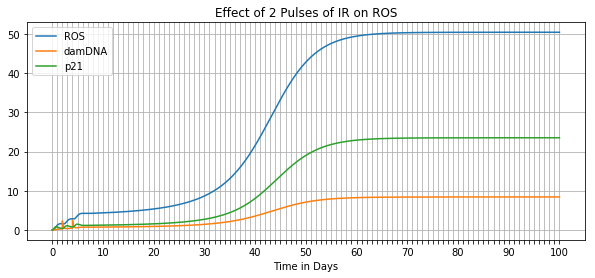

In [29]:
parameterList = ["ROS", "damDNA", "p21"]
plotNRadiationPulses(100, 2, 2)

#### Reduction of p21 Degradation
The previous exercise showed how several pulses of IR could be sufficient for senescence. However, accumulated DNA damage is not the sole reason for the aforementioned feedback loop. As long as DNA damage response foci induction occurs, ROS levels will remain high. 
<br/>
Try reducing the rate at which p21 degrades. What happens to ROS and DNA damage? This plot contains one pulse of 20 Gy IR at day 2 as usual.

In [42]:
#Reduction of kdegp21
parameterList = ["ROS", "damDNA", "p21"]
FIRST_DAY_OF_RADIATION = 2
def plotP21Degradation(maxDays, kdegp21):
    plt.figure(figsize=(10,4))
    customizePlot(plt, maxDays)

    p21Model = te.loada(modelNoEvents%(defaultEvents))
    p21Model.kdegp21 = kdegp21
    
    #Plot data
    plt.title("ROS and DNA Damage Progression")
    result = p21Model.simulate(0, DAY*maxDays, 12000, ["time"] + parameterList)    
    for i in range(0, len(parameterList)):
        plt.plot(result[:,0], result[:,i+1], label=parameterList[i])

    plt.legend()
    plt.show()
    

sliderP21 = SelectionSlider(description = 'kdegp21:', 
                                           options=[.00009, .00019, .00029],
                                           value=.00019,
                                           continuous_update=False, style=style, layout=layout)
sliderDays = IntSlider(description = 'Days in Simulation:', min=10, max=120, step=10, value=100, continuous_update=False, style=style, layout=layout)
interact(plotP21Degradation, maxDays=sliderDays, kdegp21=sliderP21);

interactive(children=(IntSlider(value=100, continuous_update=False, description='Days in Simulation:', layout=Layout(width='375px'), max=120, min=10, step=10, style=SliderStyle(description_width='auto')), SelectionSlider(continuous_update=False, description='kdegp21:', index=1, layout=Layout(width='375px'), options=(9e-05, 0.00019, 0.00029), style=DescriptionStyle(description_width='auto'), value=0.00019), Output()), _dom_classes=('widget-interact',))

If p21 degradation is reduced, the feedback loop persists and both ROS and DNA damage remain high. On the other hand, if p21 degrades quickly, the feedback loop can be interrupted such that the DNA is repaired and ROS levels decline. Therefore, p21 is critical for maintaining the senescence stress response. 

## Macroscopic Effects

The molecular species discussed in this app are part of the "five key regulators of cellular ageing: insulin-TOR, FoxO3a, DNA damage response (DDR), ROS, and mitochondrial function" (<a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4159174/">Dalle Pezze et al, 2014</a>). Mitochondrial dysfunction is a notable effect of senescence because, intuitively, it leads to less energy which is a sign of aging. In particular, senescence increases mitochondrial mass but decreases membrane potential. At the same time, the dysfunctional mitochondria also will produce more ROS.

## Summary

Signalling through CDKN1A-GADD45A-MAPK14-GRB2-TGFβ increases ROS levels following DNA damage. Although DNA damage response is an effective means of halting tumor growth via senescence, DDR foci create a self-sustaining feedback loop with ROS that replenishes these short-lived foci. Not all of the steps in this signalling network could be included in this app, but the following foci were covered:
- **p38**, when phosphorylated, generates ROS, so it was inhibited to decrease oxidative stress.
- **p53** plays a pivotal role in deciding cell fate, but it does not do so alone. Sensor kinases like ATM detect DNA damage which ultimately causes p53 to be able to activate.
- **p21** is necessary for the DDR and ROS feedback loop.

## Discussion and Further Reading

Some evidence suggests that senescence can be reversed (<a href="https://onlinelibrary.wiley.com/doi/full/10.1111/j.1474-9726.2010.00654.x">Choi et al, 2010</a>; <a href="https://pubmed.ncbi.nlm.nih.gov/12912919/">Beauséjour et al, 2003</a>). Although growth potential can be restored, that growth is still limited and a cell cannot return to its "young" state following senescence. 

<hr style="border-color: #AAAAAA"></hr>

Sources

Passos et al. https://doi.org/10.1038%2Fmsb.2010.5

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3454471/
"Reactive oxygen species (ROS) homeostasis and redox regulation in cellular signaling"

https://pubmed.ncbi.nlm.nih.gov/18206122
Matsuzawa A, Ichijo H (2008) Redox control of cell fate by MAP kinase: physiological roles of ASK1-MAP kinase pathway in stress signaling. Biochimica Et Biophysica Acta-General Subjects 1780: 1325–1336.

https://pubmed.ncbi.nlm.nih.gov/16288288
Greer EL, Brunet A (2005) FOXO transcription factors at the interface between longevity and tumor suppression. Oncogene 24: 7410–7425. [PubMed] [Google Scholar]

https://pubmed.ncbi.nlm.nih.gov/18171426
Greer EL, Brunet A (2008) FOXO transcription factors in ageing and cancer. Acta Physiologica 192: 19–28. [PubMed] [Google Scholar]
    
https://pubmed.ncbi.nlm.nih.gov/14976264
Brunet A, Sweeney LB, Sturgill JF, Chua KF, Greer PL, et al. (2004) Stress-dependent regulation of FOXO transcription factors by the SIRT1 deacetylase. Science 303: 2011–2015.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8533283/
Robert H. Whitaker and Jeanette Gowen Cook

Pabla, N. & Dong, Z. Cisplatin nephrotoxicity: mechanisms and renoprotective strategies. Kidney Int 73, 994–1007, https://doi.org/10.1038/sj.ki.5002786 (2008).

Aubrey et al.
https://www.nature.com/articles/cdd2017169)

Trino et al.
https://www.frontiersin.org/articles/10.3389/fphar.2016.00491/full OR https://doi.org/10.3389/fphar.2016.00491

Tamura et al.
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3797964/

https://pubmed.ncbi.nlm.nih.gov/12897450
Torres and Forman, 2003

https://onlinelibrary.wiley.com/doi/pdf/10.1111/cas.13184
Watanabe et al, 2017

https://pubmed.ncbi.nlm.nih.gov/12912919/ 
Beauséjour et al, 2003

https://doi.org/10.1083%2Fjcb.201708092 
McHugh and Gil, 2018